In [308]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [121]:
#LSTM without TenYear
df = pd.read_excel('InlandEmpirePredict1.xlsx')

In [122]:
df['Period'] = pd.to_datetime(df['Period'], format='%b %Y')
df = df.sort_values('Period')

In [123]:
df['RevPAR'] = df['RevPAR'].astype(str).str.replace('$', '').astype(float)

In [124]:
df.set_index('Period', inplace=True)

In [125]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['RevPAR'] = scaler.fit_transform(df[['RevPAR']])

In [126]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [127]:
time_step = 10
X, Y = create_dataset(df[['RevPAR']].values, time_step)

In [128]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [129]:
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [130]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

In [131]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [132]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
model.fit(X_train, Y_train, epochs=2, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/2
5/5 [==============================] - 6s 263ms/step - loss: 0.0339 - val_loss: 0.0810
Epoch 2/2
5/5 [==============================] - 0s 37ms/step - loss: 0.0122 - val_loss: 0.0270


In [134]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 6ms/step


In [135]:
train_predict_full = np.zeros((train_predict.shape[0], 1))
train_predict_full[:, 0] = train_predict[:, 0]
test_predict_full = np.zeros((test_predict.shape[0], 1))
test_predict_full[:, 0] = test_predict[:, 0]

In [136]:
train_predict = scaler.inverse_transform(train_predict_full)[:, 0]
test_predict = scaler.inverse_transform(test_predict_full)[:, 0]

In [137]:
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))[:, 0]
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))[:, 0]

In [138]:
train_mse = mean_squared_error(Y_train_actual, train_predict)
test_mse = mean_squared_error(Y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(Y_train_actual, train_predict)
test_mae = mean_absolute_error(Y_test_actual, test_predict)

In [139]:
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)


Train MSE:  227.97686582258098
Test MSE:  407.8785319127395
Train RMSE:  15.098902801944947
Test RMSE:  20.196002869695267
Train MAE:  13.240460875898707
Test MAE:  14.308896859617779


1/1 [==============================] - 0s 31ms/step


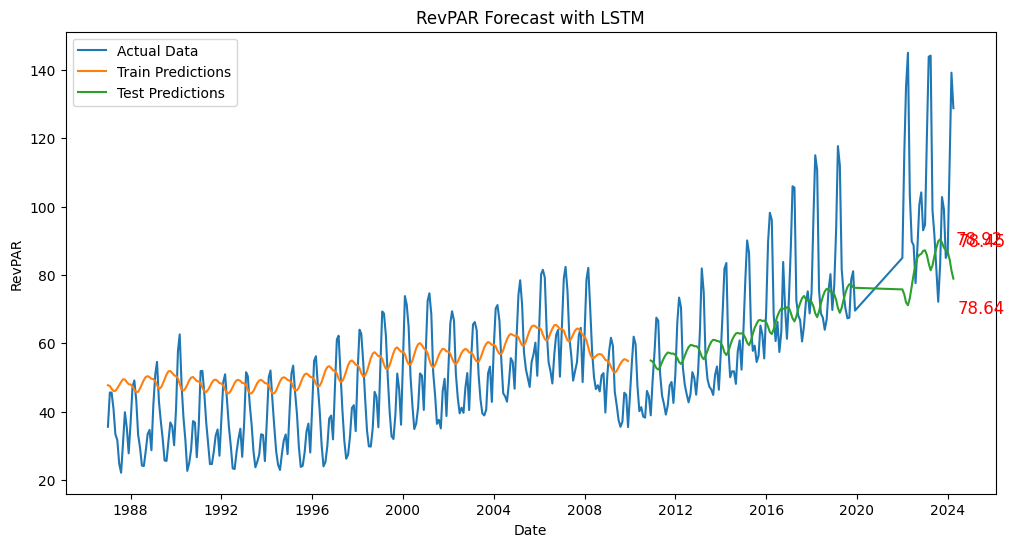

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df[['RevPAR']])[:, 0], label='Actual Data')
plt.plot(df.index[:len(train_predict)], train_predict, label='Train Predictions')
plt.plot(df.index[len(train_predict) + time_step + 1:], test_predict, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('RevPAR')
plt.title('RevPAR Forecast with LSTM')
plt.legend()

X_input = X[-1].reshape((1, time_step, 1))
forecast = []
for i in range(3):
    next_pred = model.predict(X_input)
    forecast.append(next_pred[0, 0])
    X_input = np.append(X_input[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

forecast_full = np.zeros((len(forecast), 1))
forecast_full[:, 0] = forecast
forecast = scaler.inverse_transform(forecast_full)[:, 0]

last_date = df.index[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, 4)]

for i, val in enumerate(forecast):
    offset = 10 if i % 2 == 0 else -10
    plt.text(future_dates[i], val + offset, str(round(val, 2)), color='red', fontsize=12)

plt.show()

In [233]:
print("Forecast for the next 3 months:")
for date, value in zip(future_dates, forecast):
    print(f"{date.strftime('%B %Y')}: ${value:.2f}")

Forecast for the next 3 months:
June 2024: $78.92
September 2024: $78.64
December 2024: $78.45


In [360]:
#Aparment predict
df1 = pd.read_excel('InlandEmpirePredict2.xlsx')
df1

,Period,RevPAU
0,2024 Q2,58.244800
1,2024 Q1,57.622000
2,2023 Q4,56.715600
3,2023 Q3,57.489600
4,2023 Q2,58.019533
...,...,...
93,2001 Q1,27.274500
94,2000 Q4,26.724133
95,2000 Q3,26.212667
96,2000 Q2,25.573333


In [361]:
#change Quarter string to number
def parse_quarter(string):
    year, q = string.split()
    quarter_start_month = (int(q[-1]) - 1) * 3 + 1
    return f"{year}-{quarter_start_month:02d}-01"

In [362]:
df1['Period'] = pd.to_datetime(df1['Period'].apply(parse_quarter))
df1.sort_values('Period', inplace=True)
df1.set_index('Period', inplace=True)

In [363]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1['RevPAU_scaled'] = scaler.fit_transform(df1[['RevPAU']])

In [364]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

In [365]:
time_step = 3
X, Y = create_dataset(df1['RevPAU_scaled'].values, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [366]:
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [367]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(100, return_sequences=False),
    Dense(50),
    Dense(1)
])

In [368]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [369]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 3, 100)            40800     
                                                                 
 lstm_47 (LSTM)              (None, 100)               80400     
                                                                 
 dense_33 (Dense)            (None, 50)                5050      
                                                                 
 dense_34 (Dense)            (None, 1)                 51        
                                                                 
Total params: 126301 (493.36 KB)
Trainable params: 126301 (493.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [370]:
history = model.fit(X_train, Y_train, epochs=2, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0501 - val_loss: 0.0963
Epoch 2/2
1/1 [==============================] - 0s 49ms/step - loss: 0.0401 - val_loss: 0.0797


In [371]:
X_input = df1['RevPAU_scaled'].values[-time_step:].reshape(1, time_step, 1)
predictions = []

for i in range(3):
    pred = model.predict(X_input)[0, 0]
    predictions.append(pred)

    pred_reshaped = np.array([[pred]]).reshape(1, 1, 1)

    X_input = np.append(X_input[:, 1:, :], pred_reshaped, axis=1)

1/1 [==============================] - 0s 28ms/step


In [372]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
start_of_next_quarter = pd.Timestamp('2024-04-01')
future_dates = pd.date_range(start=start_of_next_quarter, periods=3, freq='Q-DEC')

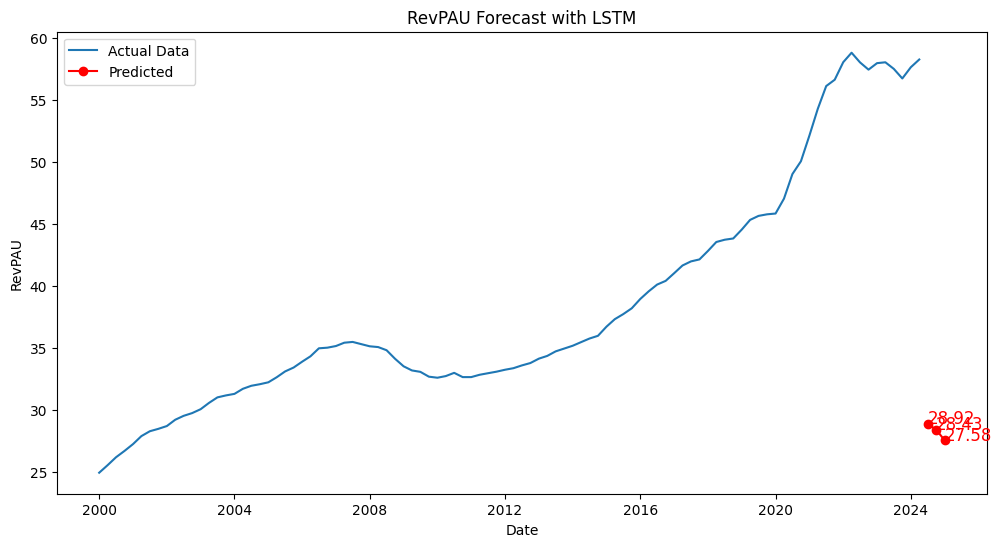

In [373]:
plt.figure(figsize=(12, 6))
plt.plot(df1.index, df1['RevPAU'], label='Actual Data')
plt.plot(future_dates, predictions, 'ro-', label='Predicted')
for date, value in zip(future_dates, predictions):
    plt.text(date, value, f'{value:.2f}', color='red', fontsize=12)
plt.title('RevPAU Forecast with LSTM')
plt.xlabel('Date')
plt.ylabel('RevPAU')
plt.legend()
plt.show()

In [374]:
print("Forecast for the next 3 months:")
for date, value in zip(future_dates, predictions):
    print(f"{date}: ${value:.2f}")

Forecast for the next 3 months:
2024-06-30 00:00:00: $28.92
2024-09-30 00:00:00: $28.43
2024-12-31 00:00:00: $27.58
